## Focus Classifier Validation

This notebook is a look at how well the [Microscope Image Quality Classifier](https://ai.googleblog.com/2018/03/using-deep-learning-to-facilitate.html) works on images of cell apartments.  This analysis will classify a random sample of files, show the "focus score" distribution, and then show different example images.

A note on the model: The predictions it produces are classes from 0-11 (0 is most "in-focus" and 11 is most degraded) and to get a more continuous measure of focus, the probability weighted class predictions are used as an overall "score" (i.e. dot product of class numbers with predicted probabilities).

In [113]:
%run -m celldom.nb.logging
import os
import os.path as osp
import celldom
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from celldom.miq import miq
from skimage import io as sk_io
from cvutils.visualize import display_images

plt.gray()
pd.set_option('display.max_colwidth', 1000)

<Figure size 432x288 with 0 Axes>

### Choose Sample Images

In [102]:
data_dir = osp.join(celldom.get_data_dir(), 'dataset', 'dataset03', 'ApartmentTraining')
files = pd.Series(glob.glob(osp.join(data_dir, '*.jpeg')))
def imread(f):
    return sk_io.imread(f)

In [103]:
len(files)

6092

In [104]:
files = files.sample(n=2500, random_state=celldom.seed)
files.head()

3623    /lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-1nMQuiz-02-05-201806021115-zm9-0263-0598-06.jpeg
61      /lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-1nMQuiz-05-02-201805311723-zp3-0544-0210-06.jpeg
2395    /lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_024_APT_034-1nMQuiz-05-12-201806020005-zm9-0543-1225-12.jpeg
1154     /lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_015_APT_014-NoDrug-05-04-201806011045-zm9-0541-0463-01.jpeg
639      /lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-11-201805312109-zm9-0267-1113-12.jpeg
dtype: object

### Score Sample Images

In [8]:
model = miq.get_classifier(celldom.get_tf_session_config())

2018-06-29 04:25:16,077:INFO:tensorflow: Restoring parameters from /lab/data/celldom/.celldom/cache/models/pretrained/miq/model.ckpt-1000042


In [105]:
scores = pd.DataFrame([
    (osp.basename(f), f, model.score(imread(f)))
    for f in files
], columns=['file', 'path', 'score']).sort_values('score')

In [106]:
scores[['file', 'score']].head()

file  \
1249  BF_ST_024_APT_034-1nMQuiz-02-06-201806011129-zp9-0266-0603-04.jpeg   
1504   BF_ST_015_APT_014-NoDrug-05-02-201806011045-zp3-0540-0209-09.jpeg   
1503  BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-zp3-0267-0337-10.jpeg   
1501  BF_ST_030_APT_006-1nMQuiz-08-11-201805312215-zm6-0815-1110-02.jpeg   
1500   BF_ST_030_APT_006-NoDrug-02-08-201805312109-zp9-0262-0854-05.jpeg   

      score  
1249    0.0  
1504    0.0  
1503    0.0  
1501    0.0  
1500    0.0

#### Score Distribution

In [110]:
scores['score'].describe()

count    2500.000000
mean        0.549972
std         0.756085
min         0.000000
25%         0.000000
50%         0.000000
75%         1.500000
max         4.500000
Name: score, dtype: float64

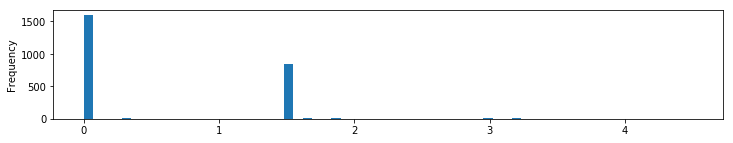

In [107]:
scores['score'].plot(kind='hist', bins=64, figsize=(12, 2))
None

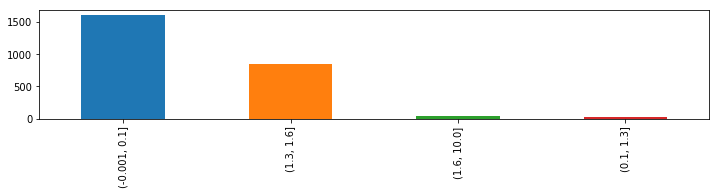

In [108]:
pd.cut(scores['score'], [0, .1, 1.3, 1.6, 10], include_lowest=True).value_counts().plot(kind='bar', figsize=(12, 2))

### High-Focus Examples

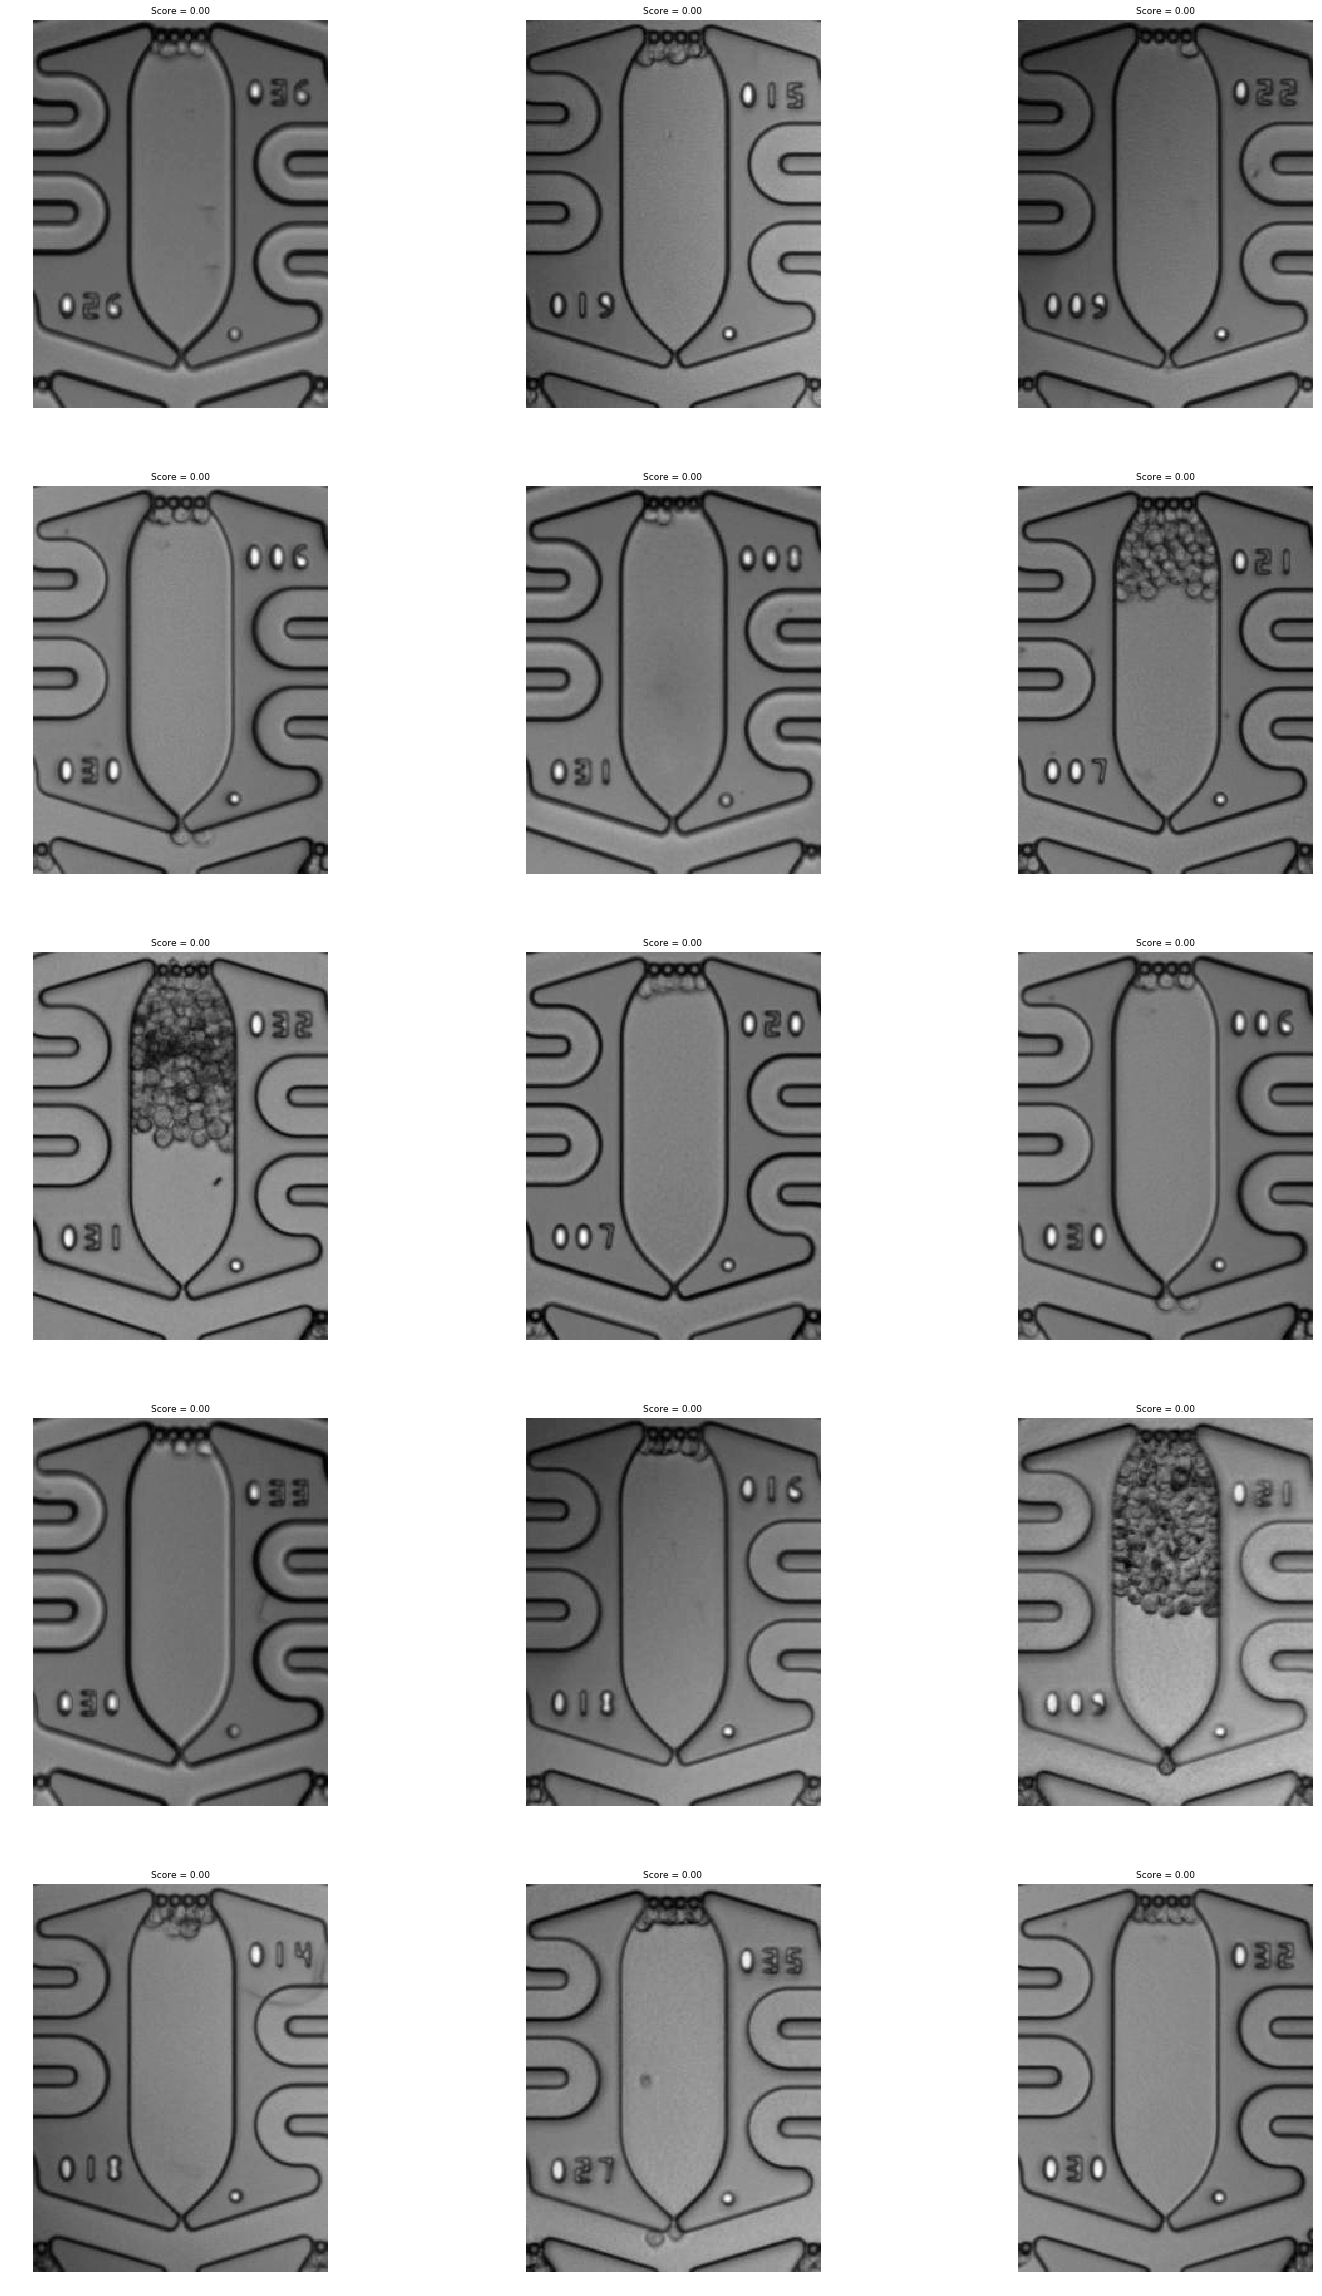

In [109]:
scores_hi = scores.head(15)
display_images(
    scores_hi['path'].apply(imread), 
    titles=scores_hi.apply(lambda r: 'Score = {:.2f}'.format(r['score']), axis=1),
    size=25, cols=3
)

### Mid-Focus Examples

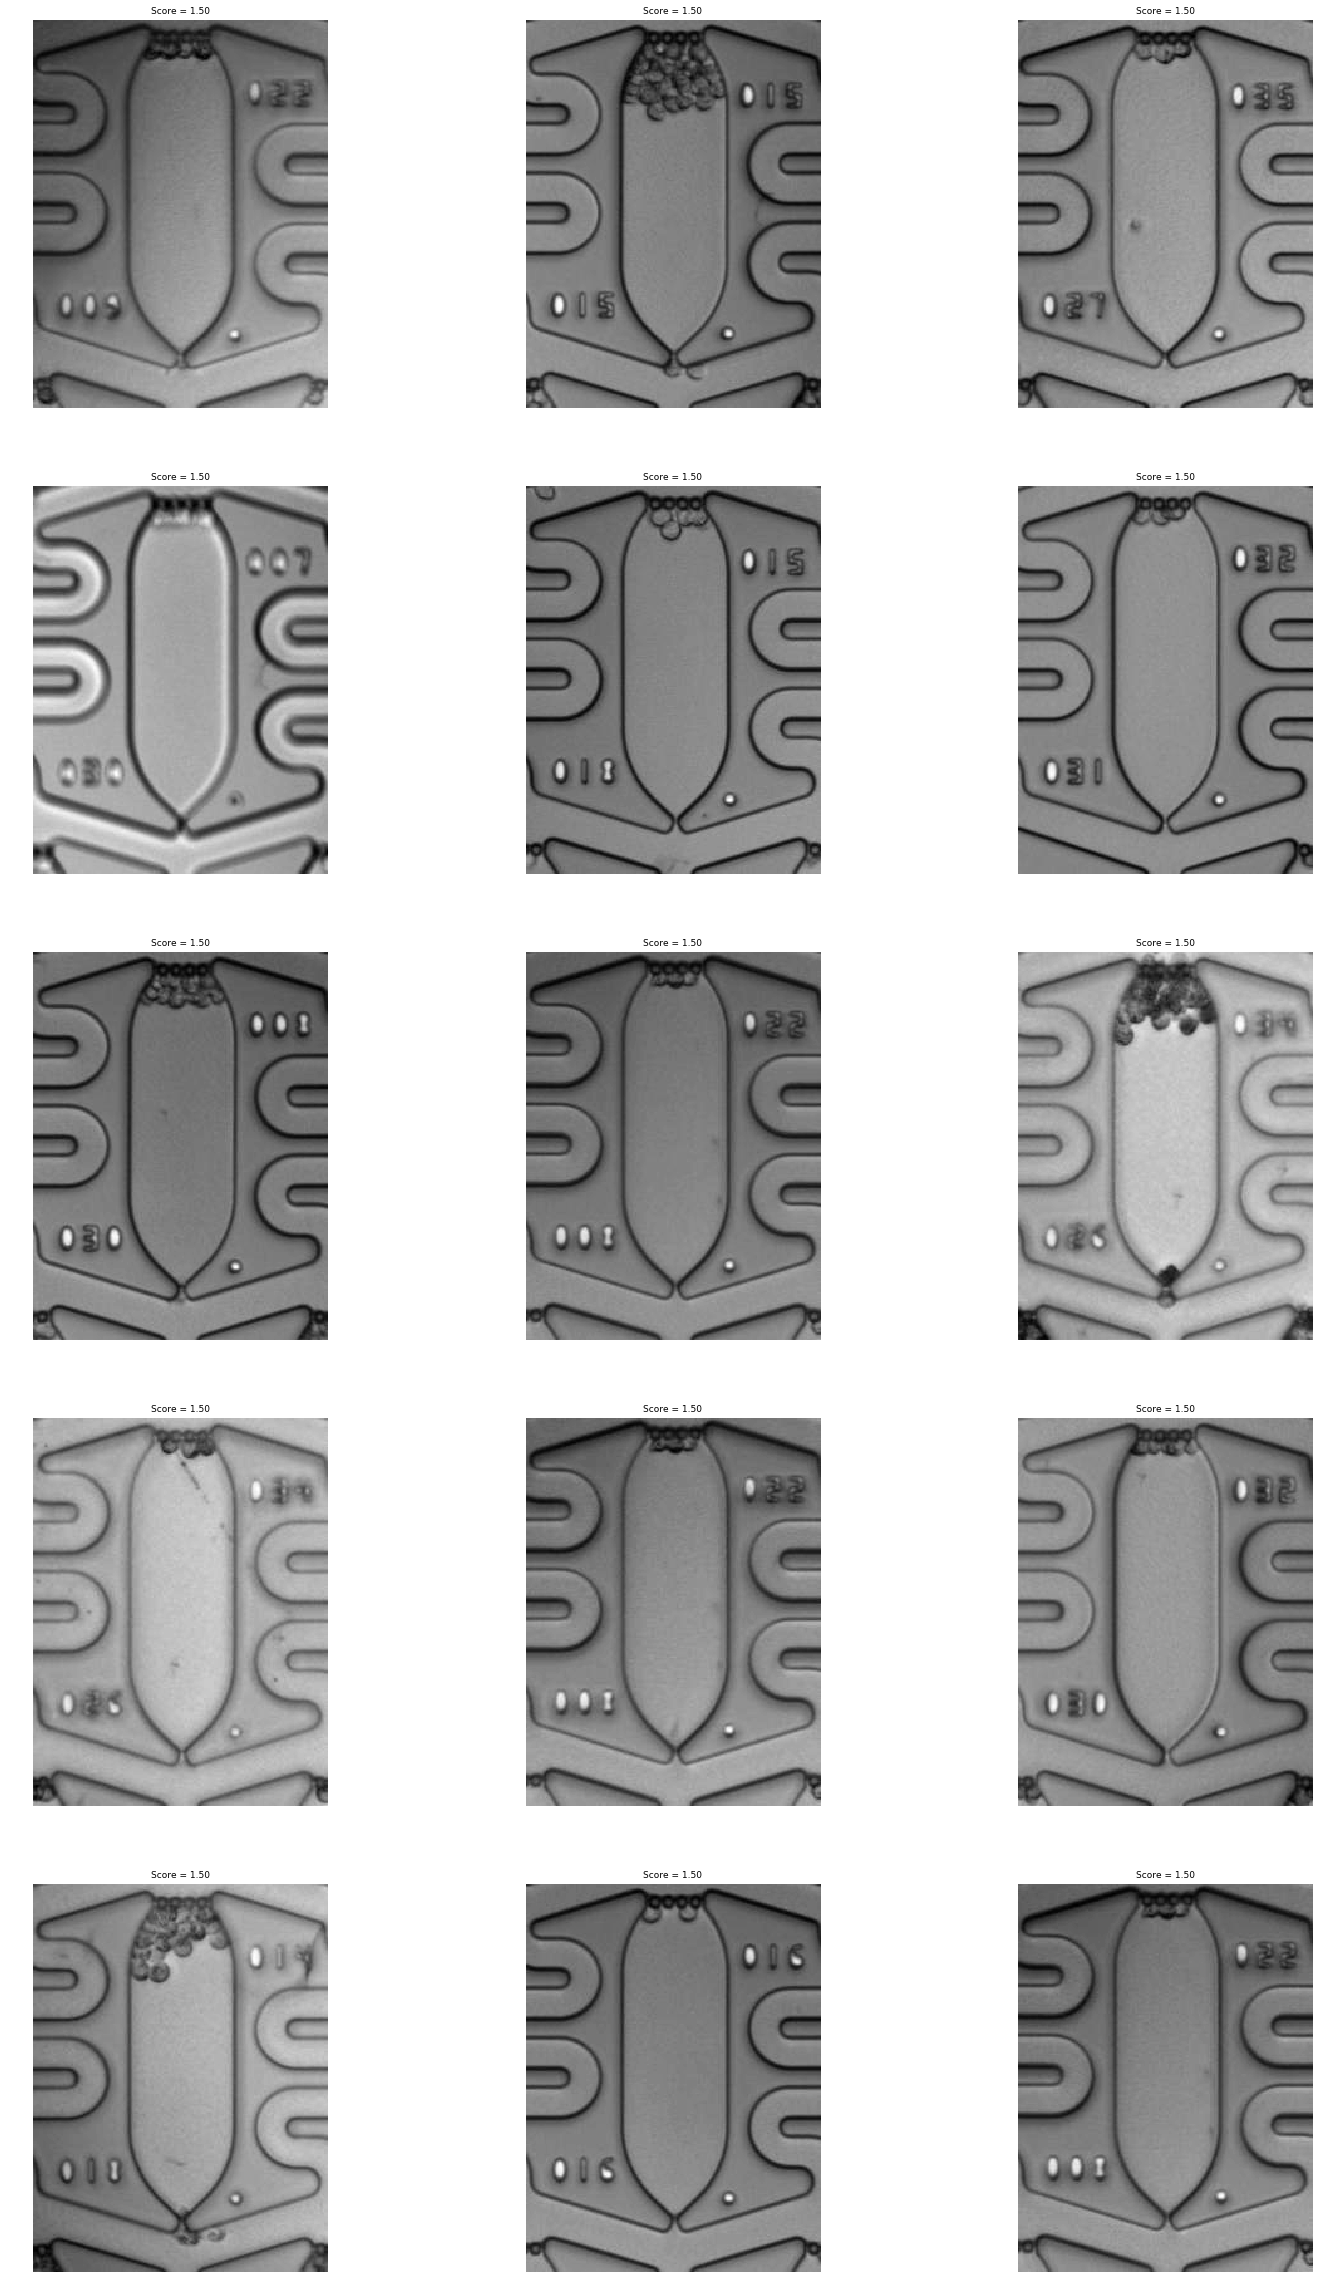

In [111]:
scores_mid = scores[scores['score'].between(1.48, 1.52)].head(15)
display_images(
    scores_mid['path'].apply(imread), 
    titles=scores_mid.apply(lambda r: 'Score = {:.2f}'.format(r['score']), axis=1),
    size=25, cols=3
)

### Low-Focus Examples

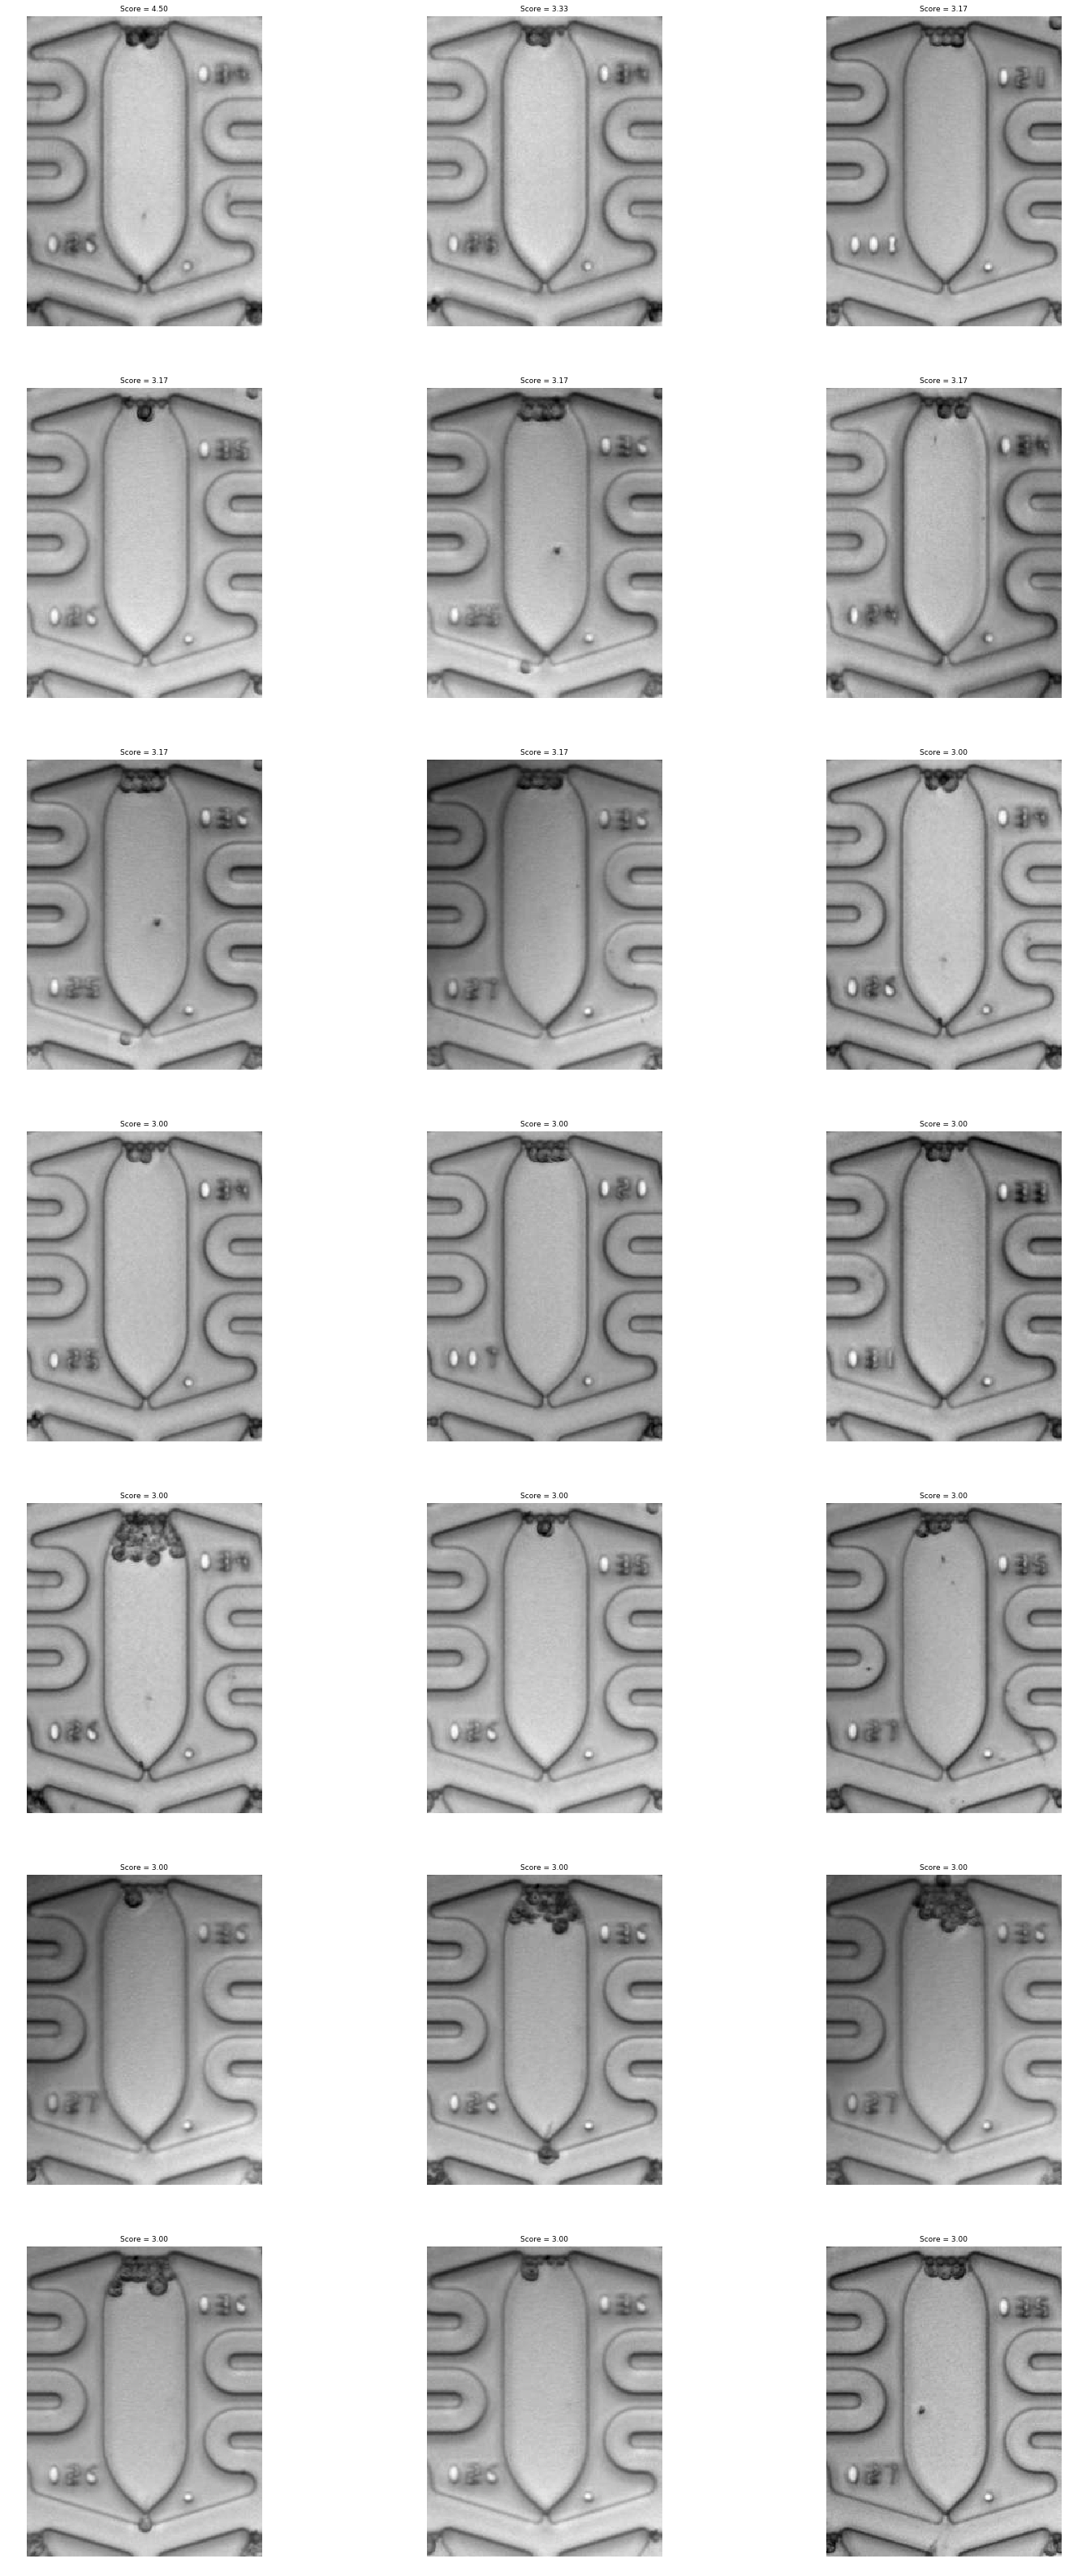

In [112]:
scores_bad = scores[scores['score'] > 1.6].tail(21)[::-1]
display_images(
    scores_bad['path'].apply(imread), 
    titles=scores_bad.apply(lambda r: 'Score = {:.2f}'.format(r['score']), axis=1),
    size=25, cols=3
)